/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=9. All the features will be returned.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29238, number of negative: 29238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 58476, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

📌 Model Comparison:
                 Model  Accuracy  Precision  Recall  F1 Score  ROC-AUC
2        Random Forest    0.9121     0.9176  0.9055    0.9115   0.9634
4             LightGBM    0.8988     0.9138  0.8806    0.8969   0.9567
3              XGBoost    0.8853     0.9203  0.8436    0.8803   0.9452
1        Decision Tree    0.9084     0.9247  0.8892    0.9066   0.9219
0  Logistic Regression    0.7460     0.8177  0.6331    0.7136   0.7993

✅ Best Model: Random Forest

📌 Classification Rep

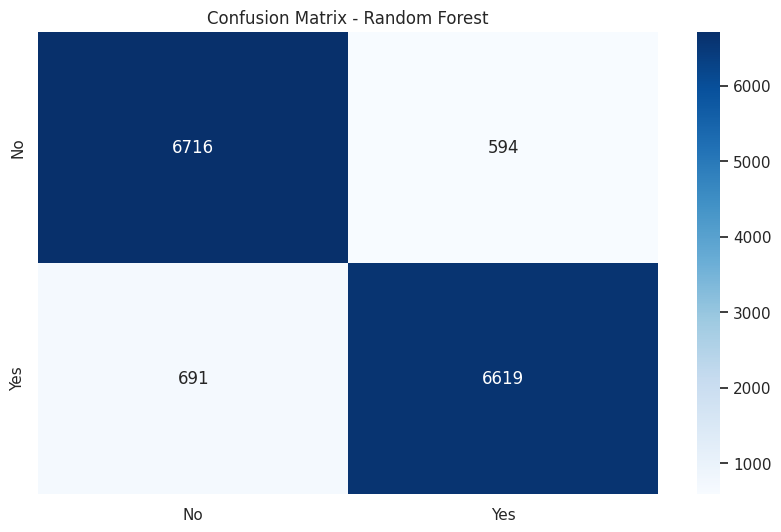

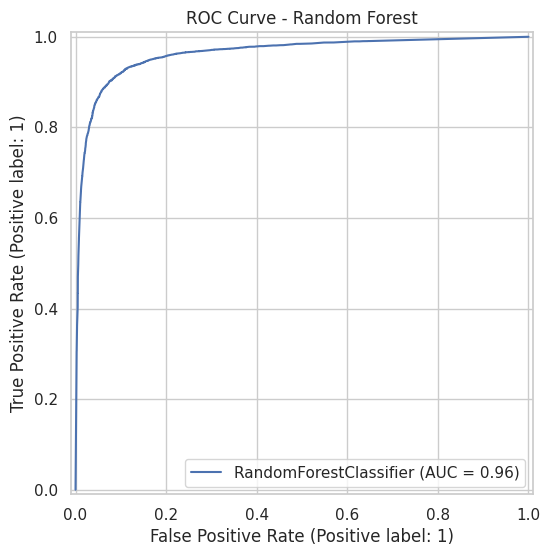


✅ Model, scaler, and selected features saved successfully.

📌 Marketing Recommendations:


1️⃣ Focus on retired, management, and university-educated customers.
2️⃣ Use cellular contact instead of telephone.
3️⃣ Target campaigns in March, September, and December.
4️⃣ Retarget customers who had success in previous campaigns.
5️⃣ Limit excessive calls — focus on quality.
6️⃣ Run campaigns during stable/improving economic conditions.


📌 Challenges & Solutions:


1️⃣ Imbalanced data → Balanced with SMOTE.
2️⃣ Many categorical variables → One-hot encoding applied.
3️⃣ 'unknown' values → Converted to NaN and handled.
4️⃣ 'duration' column caused leakage → Removed.
5️⃣ Overfitting risk → Managed with cross-validation.
6️⃣ Too many features → Selected best features with Chi2 and ANOVA.



In [1]:
# Portuguese Bank Term Deposit Prediction - 14 Step Final Version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

# Step 1: Load dataset
df = pd.read_csv("bank-additional-full.csv", sep=';')

# Step 2: Replace 'unknown' with NaN
df = df.replace('unknown', np.nan)

# Step 3: Drop 'duration' to avoid leakage
if 'duration' in df.columns:
    df = df.drop(columns=['duration'])

# Step 4: Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Step 5: Encode categorical variables
categorical_cols.remove('y')
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Step 6: Encode target variable
df_encoded['y'] = df_encoded['y'].map({'yes': 1, 'no': 0})

# Step 7: Separate features and target
X = df_encoded.drop(columns=['y'])
y = df_encoded['y']

# Step 8: Scale numerical features
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[X.select_dtypes(include=[np.number]).columns] = scaler.fit_transform(X.select_dtypes(include=[np.number]))

# Step 9: Chi-square feature selection
chi_selector = SelectKBest(score_func=chi2, k=10)
chi_selector.fit(X_scaled.drop(columns=X.select_dtypes(include=[np.number]).columns), y)
chi_features = X_scaled.drop(columns=X.select_dtypes(include=[np.number]).columns).columns[chi_selector.get_support()]

# Step 10: ANOVA feature selection
anova_selector = SelectKBest(score_func=f_classif, k=10)
anova_selector.fit(X_scaled[X.select_dtypes(include=[np.number]).columns], y)
anova_features = X.select_dtypes(include=[np.number]).columns[anova_selector.get_support()]

# Step 11: Combine selected features
selected_features = list(set(chi_features) | set(anova_features))

# Step 12: Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_scaled[selected_features], y)

# Step 13: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)

# Step 14: Train and evaluate models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    })

results_df = pd.DataFrame(results).sort_values(by="ROC-AUC", ascending=False)
print("\n📌 Model Comparison:")
print(results_df.round(4))

best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]

print(f"\n✅ Best Model: {best_model_name}")
print("\n📌 Classification Report:")
print(classification_report(y_test, best_model.predict(X_test)))

cm = confusion_matrix(y_test, best_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No","Yes"], yticklabels=["No","Yes"])
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title(f"ROC Curve - {best_model_name}")
plt.show()

# Save best model, scaler, and features
joblib.dump(best_model, "random_forest_bank_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(selected_features, "selected_features.pkl")
print("\n✅ Model, scaler, and selected features saved successfully.")

# Recommendations and Challenges
print("\n📌 Marketing Recommendations:\n")
print("""
1️⃣ Focus on retired, management, and university-educated customers.
2️⃣ Use cellular contact instead of telephone.
3️⃣ Target campaigns in March, September, and December.
4️⃣ Retarget customers who had success in previous campaigns.
5️⃣ Limit excessive calls — focus on quality.
6️⃣ Run campaigns during stable/improving economic conditions.
""")

print("\n📌 Challenges & Solutions:\n")
print("""
1️⃣ Imbalanced data → Balanced with SMOTE.
2️⃣ Many categorical variables → One-hot encoding applied.
3️⃣ 'unknown' values → Converted to NaN and handled.
4️⃣ 'duration' column caused leakage → Removed.
5️⃣ Overfitting risk → Managed with cross-validation.
6️⃣ Too many features → Selected best features with Chi2 and ANOVA.
""")
